<a href="https://colab.research.google.com/github/Rahullnitp/Big_Mart_Sales_EDA/blob/master/Big_Mart_Sales_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import  Image    #Python image ibrary
%matplotlib inline
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import sklearn
from scipy import stats
import itertools
# from module import *
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.model_selection import train_test_split,KFold,cross_val_score # for splitting the dataset into train and test set.
from sklearn.preprocessing import StandardScaler      # for standardisation of dataset .from sklearn.metrics import recall_score, roc_auc_score, f1_score , accuracy_score, classification_report, confusion_matrix
from sklearn import preprocessing
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
import lightgbm as lgb
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import mean_squared_error

# 1.Data upload and preprocessing

In [0]:
from google.colab import files
uploaded=files.upload()

Saving Submission.csv to Submission.csv
Saving Test.csv to Test.csv
Saving Train.csv to Train.csv


In [0]:
Data_train=pd.read_csv("Train.csv")
Data_test=pd.read_csv("Test.csv")
Data_submission=pd.read_csv("Submission.csv")

In [0]:
data_total = pd.concat([Data_train,Data_test], ignore_index = True)

In [0]:
print(Data_train.shape, Data_test.shape, data_total.shape)

(8523, 12) (5681, 11) (14204, 12)


In [0]:
data_total.head()

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,Tier 1,Medium,Supermarket Type1
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,Tier 3,Medium,Supermarket Type2
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,Tier 1,Medium,Supermarket Type1
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.000000,19.20,1998,OUT010,Tier 3,NaN,Grocery Store
4,Low Fat,NCD19,53.8614,994.7052,Household,0.000000,8.93,1987,OUT013,Tier 3,High,Supermarket Type1


In [0]:
# data_total["Qty_Sold"] = (data_total["Item_Outlet_Sales"]/data_total["Item_MRP"])
# data_total.head()

# 2.Data cleaning and Feature analysis

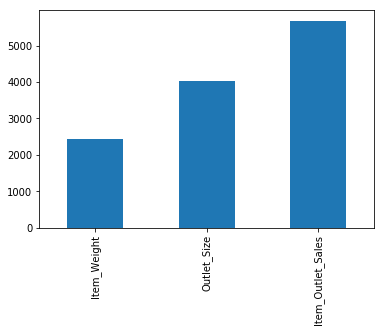

In [0]:
# Null value in total data.
Missing_Data = data_total.isnull().sum()                        # plotting the count  of missing values
Missing_Data = Missing_Data[Missing_Data > 0]             # in each feature.
Missing_Data.sort_values(inplace=True)
Missing_Data.plot.bar()

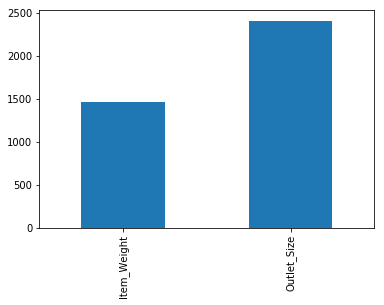

In [0]:
# Null value in the Data i.e. in training set
Missing_Data = Data_train.isnull().sum()                        # plotting the count  of missing values
Missing_Data = Missing_Data[Missing_Data > 0]             # in each feature.
Missing_Data.sort_values(inplace=True)
Missing_Data.plot.bar()

In the data_total the target feature as expected have missing values only in the Data_test . So, i have to impute the missing values in Item_Weight and Outlet_Size only.

Text(0.5, 1.0, '%_Missing_Data')

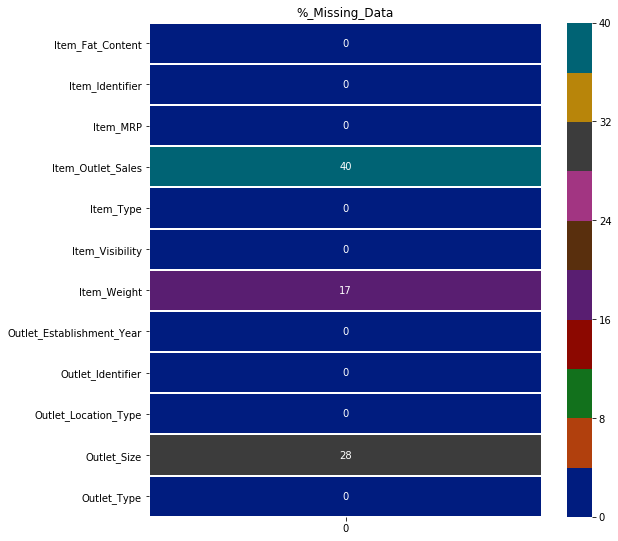

In [0]:
#percentage of missing data
plt.figure(figsize=(30,20))                        #calculating the % of missing Data for each column.
plt.subplot(234)
sns.heatmap(pd.DataFrame((data_total.isnull().sum()*100)/data_total.shape[0]),annot=True,cmap=sns.color_palette("dark"),linewidths=1,linecolor="white")
plt.title("%_Missing_Data")

Amount of missing data for ' Outlet_Size ' and ' Item_Weight' are 28% and 17% respectively,
which is very large amnt of missing data for a dataset having only 8523 data.

But on going through the dataset we can easily note that 'Item_Weight' and 'Outlet_Size'  for same 'Item_Identifier' are same. So, due to repetition of 'Item_Identifier' some of the null value can be filled.

In [0]:
data_total['Item_Weight']=data_total.sort_values(['Item_Identifier','Item_Weight']).groupby('Item_Identifier')['Item_Weight'].ffill()  # filling the null value in 'Item_Weight'
data_total['Outlet_Size']=data_total.groupby('Outlet_Type').Outlet_Size.transform(lambda x: x.fillna(x.mode()[0]))
# data_total['Outlet_Size']=data_total.sort_values(['Outlet_Identifier','Outlet_Size']).groupby('Outlet_Identifier')['Outlet_Size'].ffill()  # filling the null value in 'Outlet_Size'.

In [0]:
data_total.isnull().sum()

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                     0
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                     0
Outlet_Type                     0
dtype: int64

In [0]:
#DROP THE DUPLICATE ROWS i.e. repetition of same example

In [0]:
data_total.drop_duplicates(inplace=True)

In [0]:
data_total.dtypes

Item_Fat_Content              object
Item_Identifier               object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Type                     object
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
Outlet_Identifier             object
Outlet_Location_Type          object
Outlet_Size                   object
Outlet_Type                   object
dtype: object

In [0]:
# Remove the column with unique values . 
data_total = data_total[[col for col in data_total if not len(set(data_total[col]))==1]]

In [0]:
data_total.shape

(14204, 12)

In [0]:
column_list=data_total.columns

In [0]:
len(column_list)

12

In [0]:
data_total.describe()

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,14204.000000,8523.000000,14204.000000,14204.000000,14204.000000
mean,141.004977,2181.288914,0.065953,12.793380,1997.830681
std,62.086938,1706.499616,0.051459,4.651716,8.371664
min,31.290000,33.290000,0.000000,4.555000,1985.000000
25%,94.012000,834.247400,0.027036,8.710000,1987.000000
50%,142.247000,1794.331000,0.054021,12.600000,1999.000000
75%,185.855600,3101.296400,0.094037,16.750000,2004.000000
max,266.888400,13086.964800,0.328391,21.350000,2009.000000


In [0]:
for i in range(12):
  print(column_list[i] ,':' , len(data_total.iloc[:,i].value_counts()))

Item_Fat_Content : 5
Item_Identifier : 1559
Item_MRP : 8052
Item_Outlet_Sales : 3493
Item_Type : 16
Item_Visibility : 13006
Item_Weight : 415
Outlet_Establishment_Year : 9
Outlet_Identifier : 10
Outlet_Location_Type : 3
Outlet_Size : 3
Outlet_Type : 4



 mu = 2181.29 and sigma = 1706.40



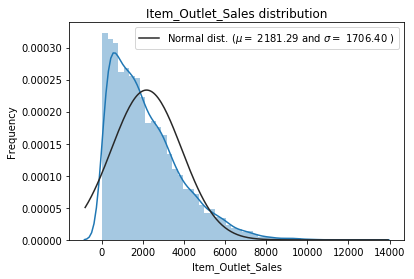

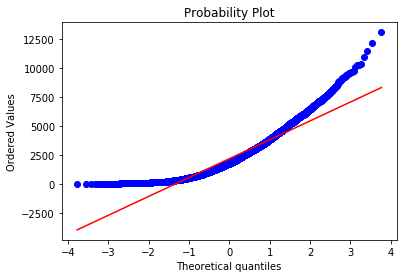

In [0]:
sns.distplot(Data_train['Item_Outlet_Sales'] , fit = norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(Data_train['Item_Outlet_Sales'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Item_Outlet_Sales distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(Data_train['Item_Outlet_Sales'], plot=plt)
plt.show()


 mu = 7.30 and sigma = 1.02



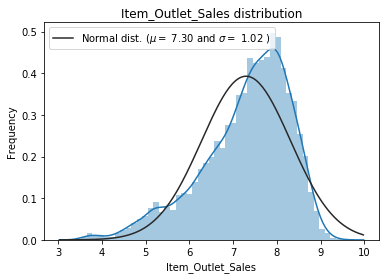

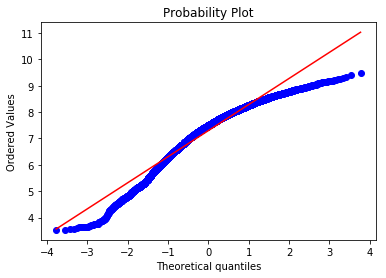

In [0]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
Data_train["Item_Outlet_Sales"] = np.log1p(Data_train["Item_Outlet_Sales"])

#Check the new distribution 
sns.distplot(Data_train['Item_Outlet_Sales'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(Data_train['Item_Outlet_Sales'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Item_Outlet_Sales distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(Data_train['Item_Outlet_Sales'], plot=plt)
plt.show()

In [0]:
len(data_total)

14204

In [0]:
continuous = [f for f in data_total.columns if data_total.dtypes[f] != 'object']
categorical =[f for f in data_total.columns if data_total.dtypes[f] == 'object']

In [0]:
continuous

['Item_MRP',
 'Item_Outlet_Sales',
 'Item_Visibility',
 'Item_Weight',
 'Outlet_Establishment_Year']

##this slides were created for outlier removal

In [0]:
# data_total1=data_total[:8523]
# data_total2=data_total[8523:]


In [0]:
# data_total2

In [0]:
# from scipy import stats
# data_total1=data_total1[data_total1[['Item_Outlet_Sales','Item_MRP','Item_Visibility','Item_Weight','Outlet_Establishment_Year']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

In [0]:
# data_total = pd.concat([data_total1,data_total2], ignore_index = True)

In [0]:
# data_total.head()

In [0]:
# len(data_total)

##outlier removal slides ends here....

In [0]:
def feature_plot(X,Y,continuous):
  
  Data=data_total[:8523]
    
  x = Data[X]
  y = Data[Y]
  
  
  if continuous:    # if the data in the given feature is continuous
    
    fig = plt.figure(constrained_layout=True,figsize=(17,6))

    # ----- assigning grid to for plotting 
    
    gs = gridspec.GridSpec(8, 8, figure=fig)
    ax1 = fig.add_subplot(gs[0:2, 5:7])
    ax2 = fig.add_subplot(gs[0:, 0:3])
    ax4 = fig.add_subplot(gs[2:,5:7])
    ax3 = fig.add_subplot(gs[2:,7:8])
    
  # # #------plot-----
    
     #-----PLOT WITHOUT "Item_Outlet_Sales"-----
    
    sns.distplot(x, kde=False, ax=ax2)
    
     #  -----PLOT WITH "Item_Outlet_Sales"------
    
    ax4.scatter(x,y)
    ax1.hist(x,bins=70)
    ax3.hist(y,bins=70,orientation="horizontal")
    
    #   fig.suptitle("GridSpec")

# Turn off tick labels on marginals
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax3.get_yticklabels(), visible=False)

# Set labels on joint
    ax4.set_xlabel(X)
    ax4.set_ylabel(Y)

# Set labels on marginals
    ax3.set_xlabel(Y+' count')
    ax1.set_ylabel(X+' count')
    
  else:     # if the data in the given feature is not continuous .
    
    fig,(ax5,ax6)=plt.subplots(nrows=1,ncols=2, figsize=(16,5),dpi=90)
    
    #-----PLOT WITHOUT "Item_Outlet_Sales"-----
    
    #Show the counts of observations in each categorical bin using bars.
    count=sns.countplot(x, order=sorted(x.unique()), color='#597500', saturation=1, ax=ax5)                                                                                                 
    count.set_xticklabels(count.get_xticklabels(), rotation=80)
    ax5.set_title(X+' count')
                                                                                                       
    
    #  -----PLOT WITH "Item_Outlet_Sales"------
    
    sns.boxplot(x=x, y=y, data=Data)
#                                                         cat_df_flights = df_flights.select_dtypes(include=['object']).copy()              #sns.catplot(x="Outlet_Type", y="Item_Outlet_Sales", kind="boxen",data=Data);
    ax6.set_ylabel('Item_Outlet_Sales')
    ax6.set_title('Item_Outlet_Sales by '+X)
    plt.xticks(rotation = 80)
  plt.show()


In [0]:
# con_data_total_train = data_total[:8523].select_dtypes(exclude=['object']).copy()

In [0]:
# con_data_total_test = data_total[8523:].select_dtypes(exclude=['object']).copy()
# con_data_total_test=con_data_total_test.drop(['Item_Outlet_Sales'],axis=1)

In [0]:
# cat_data_total = data_total.select_dtypes(include=['object']).copy()

In [0]:
# cat_data_total_test = data_total[8523:].select_dtypes(include=['object']).copy()

In [0]:
# con_data_total_train=con_data_total_train[con_data_total_train.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
# con_data_total_test=con_data_total_test[con_data_total_test.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

In [0]:
# from scipy import stats
# con_data_total=con_data_total[(np.abs(stats.zscore(con_data_total)) < 3).all(axis=1)]

In [0]:
# len(con_data_total_train)

In [0]:
# cat_data_total = cat_data_total[cat_data_total.between(cat_data_total.quantile(.25), cat_data_total.quantile(.75))]

In [0]:
# len(cat_data_total)

##    Feature Visualisation

In [0]:
continuous

['Item_MRP',
 'Item_Outlet_Sales',
 'Item_Visibility',
 'Item_Weight',
 'Outlet_Establishment_Year']

1. Feature : 'Item_Weight'

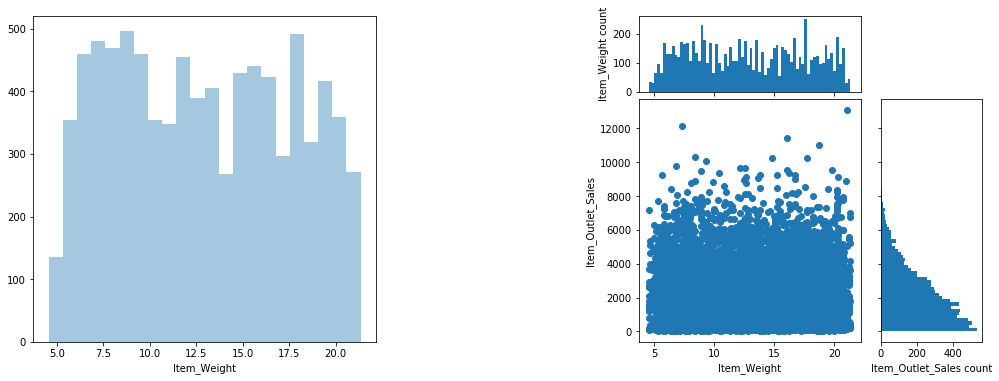

In [0]:
feature_plot('Item_Weight','Item_Outlet_Sales',True)

From the above plot , it seems like Item_Weight have a low correlation with Item_Outlet_Sales.It will more clear when we find the correlation matrix later.

2. Feature : "Item_Visibility"

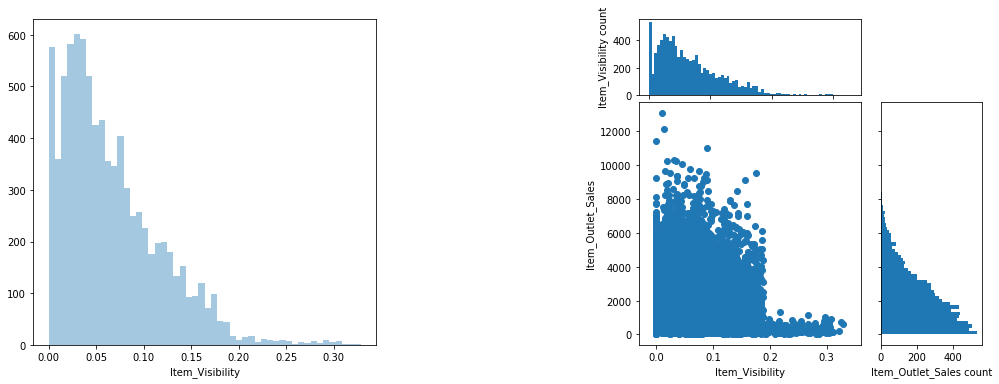

In [0]:
feature_plot('Item_Visibility','Item_Outlet_Sales',True)



* Item with higher visibility are lesser in number.
* From the above graph , we can observe that        'Item_Visibility' is inversely proportional to 'Item_Outlet_Sales' .  
But from the graph some of the product have 'Item_Visibility' is 0 which is ambiguous since every product must be visible to all customers. 
Hence i will consider it as a missing value and impute it with the mean visibility of that product.

In [0]:
sum(data_total['Item_Visibility']==0)

879

In [0]:
# Imputing the missing values in 'Item_Visibiity' column.
# Data['Item_Visibility']=Data['Item_Visibility'].fillna(Data.groupby('Item_Identifier')['Item_Visibility'].transform("mean"), inplace=True)
data_total['Item_Visibility'].replace(0,np.nan,inplace=True)
data_total['Item_Visibility'] = data_total.groupby('Item_Identifier')['Item_Visibility'].transform(lambda x: x.fillna(x.mean()))

In [0]:
sum(data_total['Item_Visibility']==0)

0

3.Feature : 'Item_MRP'

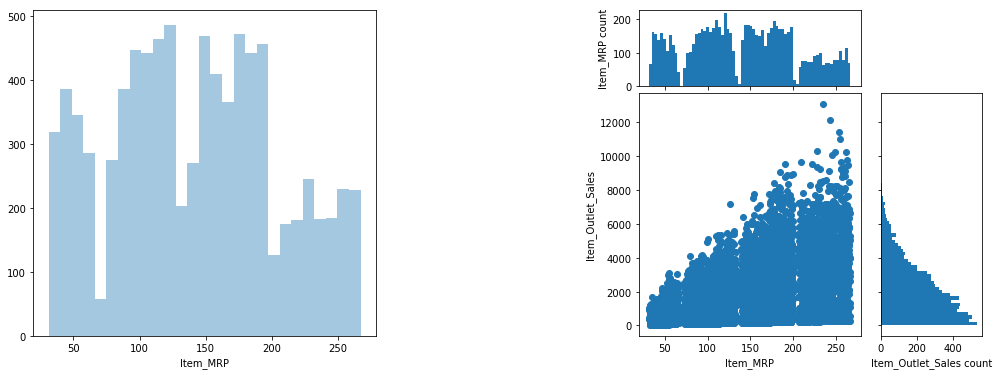

In [0]:
feature_plot('Item_MRP','Item_Outlet_Sales',True)

As the MRP of the item increases Item_Outlet_Sales also increase , i.e. 'MRP' has the positive correlation with the 'Item_Outlet_Sales'.

In [0]:
# data_total['avg_mrp']=0

In [0]:
# for i in range(len(data_total)):
#   if data_total['Item_MRP'][i]<=70 :
#     data_total['avg_mrp'][i]=50 
#   elif data_total['Item_MRP'][i]>70 and  data_total['Item_MRP'][i]<=140 :
#     data_total['avg_mrp'][i]=105
#   elif  data_total['Item_MRP'][i]>140 and  data_total['Item_MRP'][i]<=205 :
#     data_total['avg_mrp'][i]=170
#   else :
#     data_total['avg_mrp'][i]=240


In [0]:
# data_total['avg_mrp']

In [0]:
# data_total['mrp_sales']=0

In [0]:
# for i in range(len(data_total)):
#   if data_total['Item_MRP'][i]<=70 :
#     data_total['mrp_sales'][i]=900
#   elif data_total['Item_MRP'][i]>70 and  data_total['Item_MRP'][i]<=140 :
#     data_total['mrp_sales'][i]=2000
#   elif  data_total['Item_MRP'][i]>140 and  data_total['Item_MRP'][i]<=205 :
#     data_total['mrp_sales'][i]=3000
#   else :
#     data_total['mrp_sales'][i]=4000

In [0]:
# data_total['mrp_sales']

4. Feature : 'Outlet_Establishment_Year'

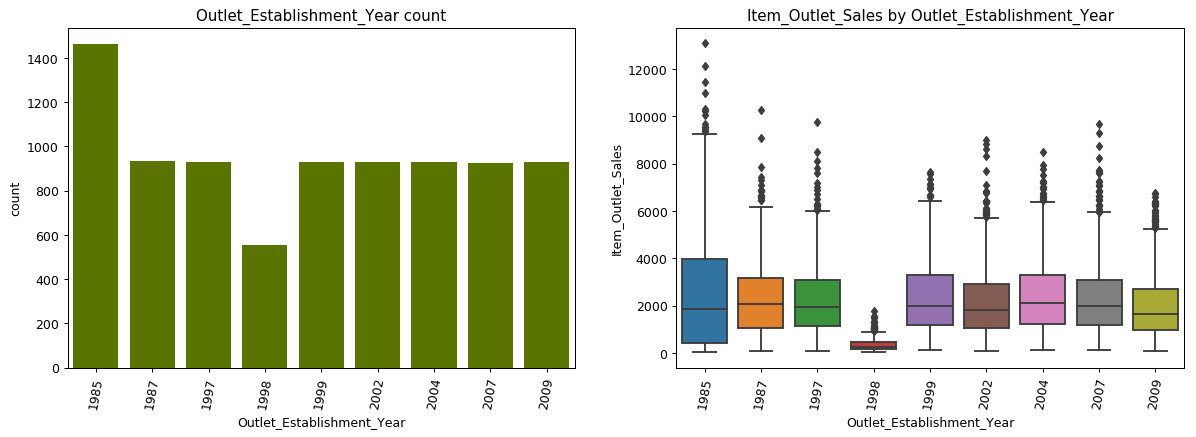

In [0]:
feature_plot('Outlet_Establishment_Year','Item_Outlet_Sales',False)

From the plot it can be easily concluded that Establishment year of a store and the sales have no significant relation bn them.
But we can make this feature usefull by extracting some important inormation like depicting the years of operation of store.
As the data is from 2013 ,so we will calculate outlet year w.r.t. 2013.

In [0]:
# new Feature : Outlet_Years
data_total['Outlet_Years'] = 2013 - data_total['Outlet_Establishment_Year']
data_total['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

In [0]:
categorical

['Item_Fat_Content',
 'Item_Identifier',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Location_Type',
 'Outlet_Size',
 'Outlet_Type']

5 . Feature : 'Item_Type'

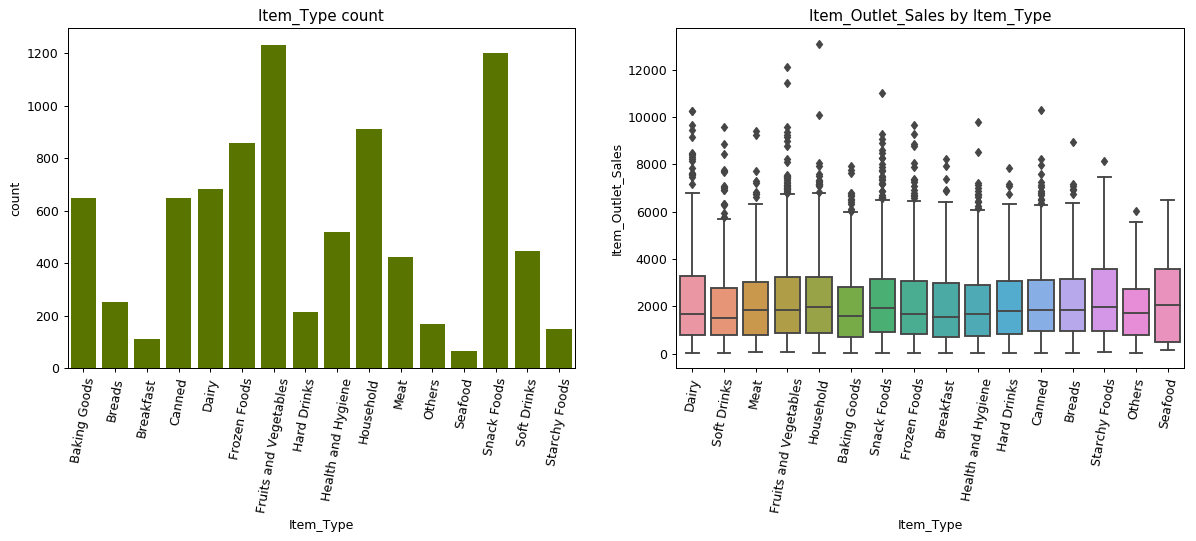

In [0]:
feature_plot('Item_Type','Item_Outlet_Sales',False)


*  Item type , as from the above plot have 16 different categories and it's very difficult to gather information from large no. of category.  
*  With the variation in the item_type , Item_Outlet_Sales have very little variation which shows that this feature is not usefull for our model.
*   For making this feature discriminatory i.e. usefull for our feature , first we will try to narrow this variation such as to gather some information.  
As in Item_Identifier of each item  the  first two letter represent a category  which distribute the item type  in three categories like  :  
'FD' = 'Food'    
'NC' = 'Non-Consumable'  
'DR' = 'Drinks'


In [0]:
# make a new feature
# Feature : 'Combined_Item_Type'
data_total['Combined_Item_Type'] = data_total['Item_Identifier'].apply(lambda x: x[0:2])
data_total['Combined_Item_Type'] = data_total['Combined_Item_Type'].map({'FD':'Food','NC':'Non-Consumable','DR':'Drinks'})
data_total['Combined_Item_Type'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Combined_Item_Type, dtype: int64

6 . Feature : 'Item_Fat_Content'

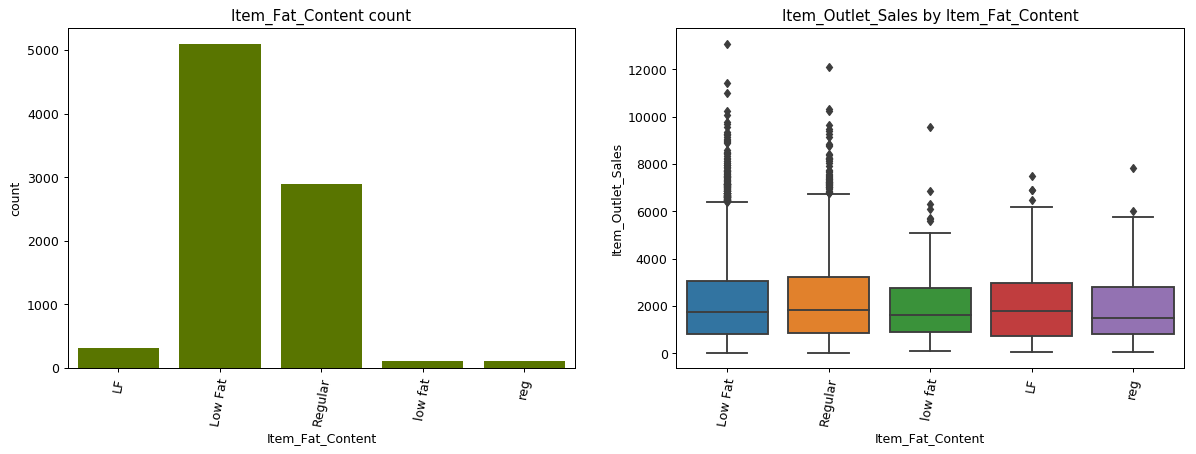

In [0]:
# Feature : 'Item_Fat_Content'
feature_plot('Item_Fat_Content','Item_Outlet_Sales',False)

In the feature column 'Item_Fat_content' ,the fat content  Low Fat , low fat and LF are the label for the
same amount of fat content i.e. for Low Fat and similarly for Regular and reg are for Regular fat content .      
So, i will make a new feature column of Item fat content with label Low fat and Regular.

In [0]:
data_total['Item_Fat_Content'] = data_total['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'})
print(data_total['Item_Fat_Content'].value_counts())

Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


But from the 6th feature, some of the products are non-consumable . So, we can calssify the fat content in three parts :

*   Low Fat
*   Regular
*   Non-Edible





In [0]:
data_total.loc[data_total['Combined_Item_Type']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"

In [0]:
print(data_total['Item_Fat_Content'].value_counts())

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64


7 . Feature : 'Outlet_Identifier'

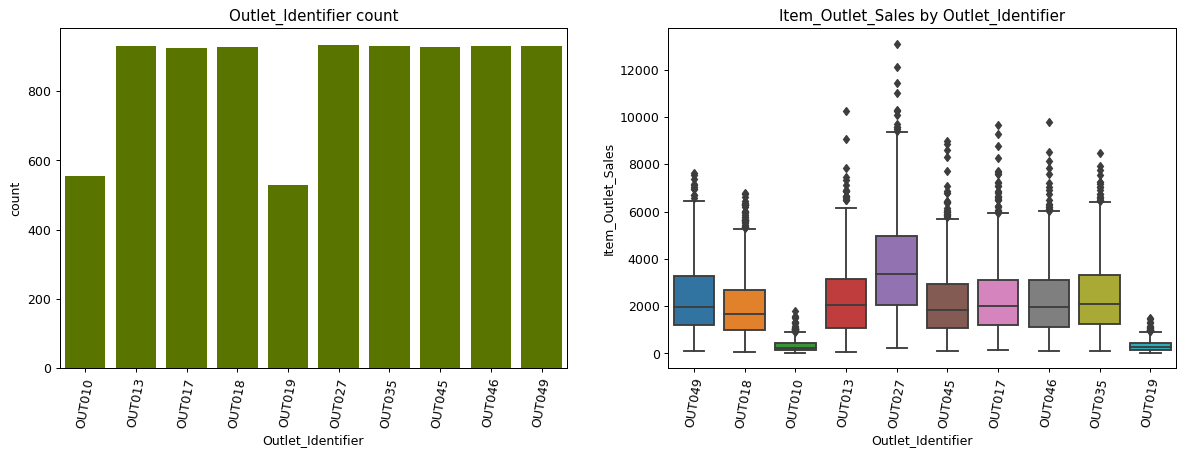

In [0]:
feature_plot('Outlet_Identifier','Item_Outlet_Sales',False)

In [0]:
data_total.groupby('Outlet_Identifier')['Outlet_Size','Outlet_Type'].first().reset_index()

,Outlet_Identifier,Outlet_Size,Outlet_Type
0,OUT010,Small,Grocery Store
1,OUT013,High,Supermarket Type1
2,OUT017,Small,Supermarket Type1
3,OUT018,Medium,Supermarket Type2
4,OUT019,Small,Grocery Store
5,OUT027,Medium,Supermarket Type3
6,OUT035,Small,Supermarket Type1
7,OUT045,Small,Supermarket Type1
8,OUT046,Small,Supermarket Type1
9,OUT049,Medium,Supermarket Type1


From the above  plot and the graph , the grocery stores (“OUT010” and  “OUT019”) as expected have lowest sales followed by supermarket type 2 (“OUT018”) and the 'Out027' have the highest sales which i can't expect as it is supermarket type 3 with medium size while supermarket type 1 with size high have lower sales.

8 . Feature : 'Outlet_Size'

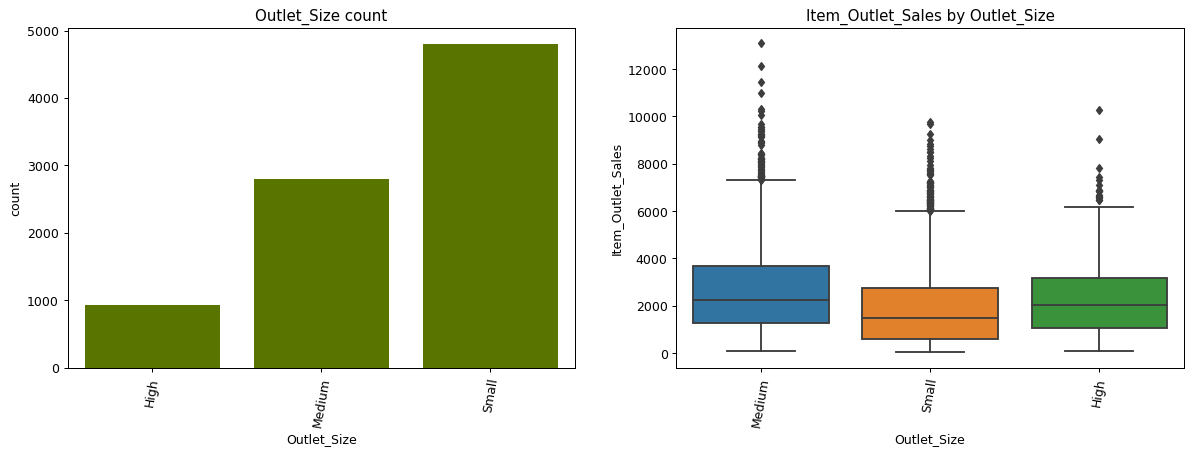

In [0]:
feature_plot('Outlet_Size','Item_Outlet_Sales',False)

From this plot ,  the Outlet type with size medium have higher sales than others as also in previous plot 'OUT027' with medium size have the highest sale .
it means consumers prefer medium size store instead of big size.

9. Feature : 'Outlet_Location_Type'

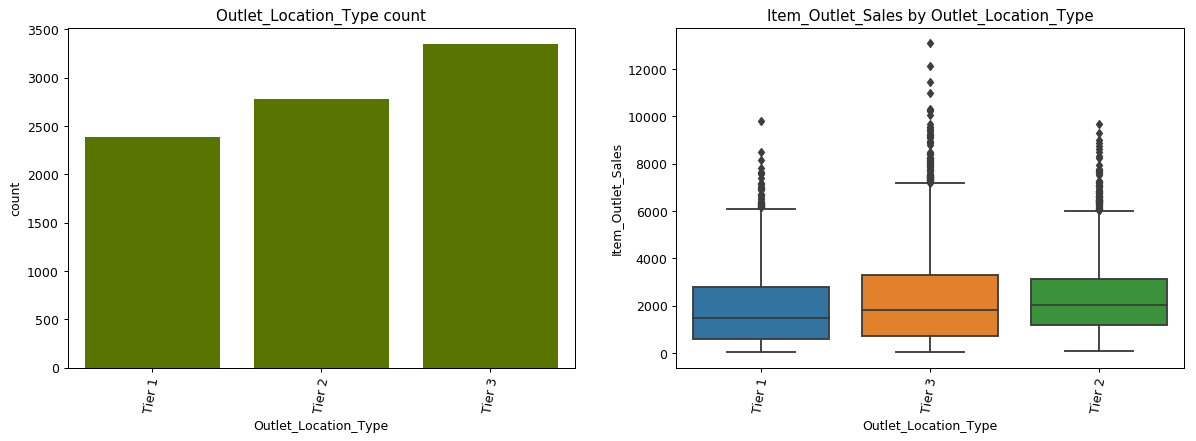

In [0]:
feature_plot('Outlet_Location_Type','Item_Outlet_Sales',False)

from the above plot also we got an unexpected result as the Tier 1 cities have the lowest sales while Tier 2 with the highest sale.

10. Feature : 'Outlet_Type'

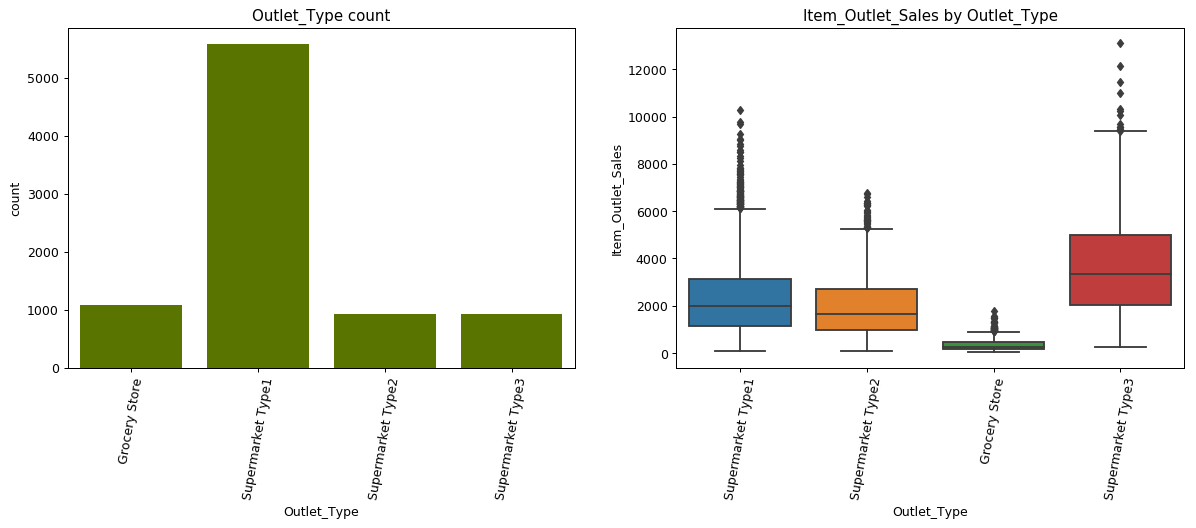

In [0]:
feature_plot('Outlet_Type','Item_Outlet_Sales',False)

From the count plot supermarket type 1 are highest in number while others three all approximately equal in count.
As expected Grocery store have the lowest sales but supermarket type 3 have the highest sales.



In [0]:
# le = preprocessing.LabelEncoder()
# Data.Item_Identifier = Data.Item_Identifier.astype("category", categories=np.unique(Data.Item_Identifier)).cat.codes
# Data.Item_Fat_Content = Data.Item_Fat_Content.astype("category", categories=np.unique(Data.Item_Fat_Content)).cat.codes
# Data.Item_Type = Data.Item_Type.astype("category", categories=np.unique(Data.Item_Type)).cat.codes
# Data.Outlet_Identifier = Data.Outlet_Identifier.astype("category", categories=np.unique(Data.Outlet_Identifier)).cat.codes
# Data['Outlet_Size'] = le.fit_transform(Data['Outlet_Size'].astype(str))
# Data.Outlet_Size = Data.Outlet_Size.astype("category", categories=np.unique(Data.Outlet_Size)).cat.codes
# Data.Outlet_Location_Type = Data.Outlet_Location_Type.astype("category", categories=np.unique(Data.Outlet_Location_Type)).cat.codes
# Data.Outlet_Type = Data.Outlet_Type.astype("category", categories=np.unique(Data.Outlet_Type)).cat.codes

In [0]:
# Data['Item_Weight'] = Data['Item_Weight'].astype(float)
# Data['Item_Visibility'] = Data['Item_Visibility'].astype(float)
# Data['Item_MRP'] = Data['Item_MRP'].astype(float)
# Data['Outlet_Establishment_Year'] = Data['Outlet_Establishment_Year'].astype(float)
# Data['Item_Outlet_Sales'] = Data['Item_Outlet_Sales'].astype(float)

## EXPLORATORY ANALYSIS OF FEATURES

In [0]:
data_total.head(10)

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,Outlet_Years,Combined_Item_Type
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.300,1999,OUT049,Tier 1,Medium,Supermarket Type1,14,Food
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.920,2009,OUT018,Tier 3,Medium,Supermarket Type2,4,Drinks
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.500,1999,OUT049,Tier 1,Medium,Supermarket Type1,14,Food
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.022930,19.200,1998,OUT010,Tier 3,Small,Grocery Store,15,Food
4,Non-Edible,NCD19,53.8614,994.7052,Household,0.014670,8.930,1987,OUT013,Tier 3,High,Supermarket Type1,26,Non-Consumable
5,Regular,FDP36,51.4008,556.6088,Baking Goods,0.091294,10.395,2009,OUT018,Tier 3,Medium,Supermarket Type2,4,Food
6,Regular,FDO10,57.6588,343.5528,Snack Foods,0.012741,13.650,1987,OUT013,Tier 3,High,Supermarket Type1,26,Food
7,Low Fat,FDP10,107.7622,4022.7636,Snack Foods,0.127470,19.000,1985,OUT027,Tier 3,Medium,Supermarket Type3,28,Food
8,Regular,FDH17,96.9726,1076.5986,Frozen Foods,0.016687,16.200,2002,OUT045,Tier 2,Small,Supermarket Type1,11,Food
9,Regular,FDU28,187.8214,4710.5350,Frozen Foods,0.094450,19.200,2007,OUT017,Tier 2,Small,Supermarket Type1,6,Food


now we have to encode the categorical feature having string values to float so that we can use that numerical value in predictive models.

In [0]:
# replace_Outlet_Identifier = {'Outlet_Identifier': {'OUT010': 1, 'OUT019': 2, 'OUT049': 3, 'OUT046': 5,
#                                   'OUT045': 4, 'OUT017': 6, 'OUT018': 7 , 'OUT013': 8 , 'OUT035': 9,'OUT027': 10}}
# data_total.replace(replace_Outlet_Identifier, inplace=True)

In [0]:
# replace_Outlet_Location_Type = {'Outlet_Location_Type': {"Tier 2":3,"Tier 1":1,"Tier 3":2}}
# data_total.replace(replace_Outlet_Location_Type, inplace=True)

In [0]:
# replace_Outlet_Size = {'Outlet_Size': {"Medium":3,"Small":1,"High":2}}
# data_total.replace(replace_Outlet_Size, inplace=True)

In [0]:
# replace_Outlet_Type = {'Outlet_Type': {"Supermarket Type3":4,"Supermarket Type1":3,"Supermarket Type2":2,"Grocery Store":1}}
# data_total.replace(replace_Outlet_Type, inplace=True)

In [0]:

data_total.Item_Fat_Content = data_total.Item_Fat_Content.astype("category", categories=np.unique(data_total.Item_Fat_Content)).cat.codes
#data_total.Outlet_Identifier = data_total.Outlet_Identifier.astype("category", categories=np.unique(data_total.Outlet_Identifier)).cat.codes
data_total.Outlet_Size = data_total.Outlet_Size.astype("category", categories=np.unique(data_total.Outlet_Size)).cat.codes
data_total.	Combined_Item_Type = data_total.	Combined_Item_Type.astype("category", categories=np.unique(data_total.	Combined_Item_Type)).cat.codes
data_total.Outlet_Location_Type = data_total.Outlet_Location_Type.astype("category", categories=np.unique(data_total.Outlet_Location_Type)).cat.codes
data_total.Outlet_Type = data_total.Outlet_Type.astype("category", categories=np.unique(data_total.Outlet_Type)).cat.codes

In [0]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# #New variable for outlet
# # data_total['Outlet'] = le.fit_transform(data_total['Outlet_Identifier'])
# var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Identifier','Outlet_Size','Combined_Item_Type','Outlet_Type']
# for i in var_mod:
#     data_total[i] = le.fit_transform(data_total[i])

In [0]:
data_total = pd.get_dummies(data_total, columns =['Outlet_Identifier'])
data_total.dtypes

Item_Fat_Content                int8
Item_Identifier               object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Type                     object
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
Outlet_Location_Type            int8
Outlet_Size                     int8
Outlet_Type                     int8
Outlet_Years                   int64
Combined_Item_Type              int8
Outlet_Identifier_OUT010       uint8
Outlet_Identifier_OUT013       uint8
Outlet_Identifier_OUT017       uint8
Outlet_Identifier_OUT018       uint8
Outlet_Identifier_OUT019       uint8
Outlet_Identifier_OUT027       uint8
Outlet_Identifier_OUT035       uint8
Outlet_Identifier_OUT045       uint8
Outlet_Identifier_OUT046       uint8
Outlet_Identifier_OUT049       uint8
dtype: object

In [0]:
data_total.head(10)

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Location_Type,Outlet_Size,Outlet_Type,Outlet_Years,Combined_Item_Type,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,0,FDA15,249.8092,3735.1380,Dairy,0.016047,9.300,1999,0,1,1,14,1,0,0,0,0,0,0,0,0,0,1
1,2,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.920,2009,2,1,2,4,0,0,0,0,1,0,0,0,0,0,0
2,0,FDN15,141.6180,2097.2700,Meat,0.016760,17.500,1999,0,1,1,14,1,0,0,0,0,0,0,0,0,0,1
3,2,FDX07,182.0950,732.3800,Fruits and Vegetables,0.022930,19.200,1998,2,2,0,15,1,1,0,0,0,0,0,0,0,0,0
4,1,NCD19,53.8614,994.7052,Household,0.014670,8.930,1987,2,0,1,26,2,0,1,0,0,0,0,0,0,0,0
5,2,FDP36,51.4008,556.6088,Baking Goods,0.091294,10.395,2009,2,1,2,4,1,0,0,0,1,0,0,0,0,0,0
6,2,FDO10,57.6588,343.5528,Snack Foods,0.012741,13.650,1987,2,0,1,26,1,0,1,0,0,0,0,0,0,0,0
7,0,FDP10,107.7622,4022.7636,Snack Foods,0.127470,19.000,1985,2,1,3,28,1,0,0,0,0,0,1,0,0,0,0
8,2,FDH17,96.9726,1076.5986,Frozen Foods,0.016687,16.200,2002,1,2,1,11,1,0,0,0,0,0,0,0,1,0,0
9,2,FDU28,187.8214,4710.5350,Frozen Foods,0.094450,19.200,2007,1,2,1,6,1,0,0,1,0,0,0,0,0,0,0


Drop the column which have been converted to different types :

In [0]:
data_total.drop(['Item_Type','Outlet_Establishment_Year','Item_Identifier'],axis=1,inplace=True)

Now i am going find the relation between target column and other features which is one of the way identify useless and collinear features.

In [0]:
Data=data_total[:8523]

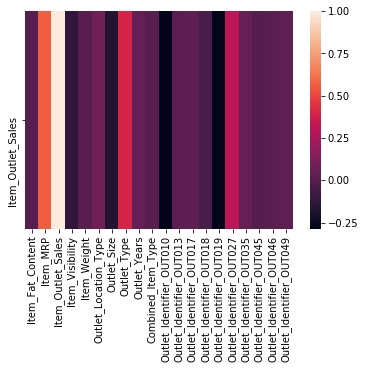

In [0]:
sns.heatmap(Data.corr().loc[['Item_Outlet_Sales'],:])

Numerical represantation of above plot is shown below.

In [0]:
Data.corr().loc['Item_Outlet_Sales',:].sort_values(ascending = False)

Item_Outlet_Sales           1.000000
Item_MRP                    0.567574
Outlet_Type                 0.401522
Outlet_Identifier_OUT027    0.311192
Outlet_Location_Type        0.089367
Outlet_Identifier_OUT035    0.052823
Outlet_Years                0.049135
Outlet_Identifier_OUT049    0.034264
Outlet_Identifier_OUT017    0.032610
Outlet_Identifier_OUT013    0.024170
Outlet_Identifier_OUT046    0.019803
Item_Fat_Content            0.015249
Item_Weight                 0.013261
Combined_Item_Type          0.011236
Outlet_Identifier_OUT045    0.002274
Outlet_Identifier_OUT018   -0.038059
Item_Visibility            -0.127014
Outlet_Size                -0.162753
Outlet_Identifier_OUT019   -0.277250
Outlet_Identifier_OUT010   -0.284883
Name: Item_Outlet_Sales, dtype: float64

Combined_Item_Type have the least correlation with the target variable 'Item_Outlet_Sales' but we will keep it because it efficient to help in predictive model.

Now  i will find the relationship bn different features in the numerical form in descending form and i will drop the feature with very high correlation i.e. value close to 1

In [0]:
corr_matrix = Data.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))

In [0]:
sol

Outlet_Type           Outlet_Identifier_OUT027    0.792834
Outlet_Size           Outlet_Identifier_OUT013    0.745682
Item_MRP              Item_Outlet_Sales           0.567574
Outlet_Years          Outlet_Identifier_OUT027    0.538072
Outlet_Location_Type  Outlet_Size                 0.480075
                      Outlet_Identifier_OUT049    0.479230
                      Outlet_Identifier_OUT046    0.479230
                      Outlet_Type                 0.467219
Outlet_Years          Outlet_Identifier_OUT018    0.466336
                      Outlet_Identifier_OUT013    0.453388
Outlet_Size           Outlet_Years                0.425534
Item_Outlet_Sales     Outlet_Type                 0.401522
Outlet_Size           Outlet_Type                 0.401373
Outlet_Type           Outlet_Identifier_OUT010    0.398067
Outlet_Years          Outlet_Identifier_OUT019    0.393918
Outlet_Type           Outlet_Identifier_OUT019    0.387608
Outlet_Location_Type  Outlet_Identifier_OUT027    0.3831

In [0]:
# data_total.drop(['Outlet_Type_Supermarket Type2','Outlet_Type_Supermarket Type3'],axis=1,inplace=True)

In [0]:
# Data=data_total[:8338]

None the features are highly correlated highest correlation is only 0.716176 ,so i will keep all the feature.

# MODEL BUILDING

## Data standardization 


*  In the Dataset the range of values for different feature varies on a very different range . So , i will standardised every feature to make their range same.
* but firstly we have to spit the dataset into feature and target set.



In [0]:
xtrain = Data.drop(['Item_Outlet_Sales'] , axis = 1)
ytrain = Data.Item_Outlet_Sales
# xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=0)
xtrain_scaled = StandardScaler().fit_transform(xtrain.values)

In [0]:
xtest=data_total[8523:].drop(['Item_Outlet_Sales'],axis=1)
xtest_scaled = StandardScaler().fit_transform(xtest.values)
ytest=Data_submission["Item_Outlet_Sales"]

Light GBM

In [0]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate*np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [0]:
import lightgbm as lgb
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(xtest_scaled,ytest)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [0]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [0]:
n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMRegressor(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [0]:
gs.fit(xtrain_scaled, ytrain, **fit_params)

In [0]:
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Best score reached: 0.5952238712125031 with params: {'colsample_bytree': 0.8665631328558623, 'min_child_samples': 122, 'min_child_weight': 0.1, 'num_leaves': 48, 'reg_alpha': 2, 'reg_lambda': 50, 'subsample': 0.7252600946741159} 


In [0]:
opt_parameters = {'colsample_bytree': 0.8665631328558623, 'min_child_samples': 122, 'min_child_weight': 0.1, 'num_leaves': 48, 'reg_alpha': 2, 'reg_lambda': 50, 'subsample': 0.7252600946741159}

In [0]:
clf_sw = lgb.LGBMRegressor(**clf.get_params())
#set optimal parameters
clf_sw.set_params(**opt_parameters)

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.8665631328558623, importance_type='split',
              learning_rate=0.1, max_depth=-1, metric='None',
              min_child_samples=122, min_child_weight=0.1, min_split_gain=0.0,
              n_estimators=5000, n_jobs=4, num_leaves=48, objective=None,
              random_state=314, reg_alpha=2, reg_lambda=50, silent=True,
              subsample=0.7252600946741159, subsample_for_bin=200000,
              subsample_freq=0)

In [0]:
gs_sample_weight = GridSearchCV(estimator=clf_sw, 
                                param_grid={'scale_pos_weight':[1,2,6,12]},             
                                cv=5,
                                refit=True,
                                verbose=True)

In [0]:
gs_sample_weight.fit(xtrain_scaled, ytrain, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training until validation scores don't improve for 30 rounds.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Early stopping, best iteration is:
[42]	valid's auc: 0.998209
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[39]	valid's auc: 0.998685
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[44]	valid's auc: 0.997168
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[67]	valid's auc: 0.998808
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.997338
Early stopping, best iteration is:
[72]	valid's auc: 0.998892
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[42]	valid's auc: 0.998209
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[39]	valid's auc: 0.998685
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[44]	valid's auc: 0.997168
Training until validation scores don't imp

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   10.3s finished


Early stopping, best iteration is:
[41]	valid's auc: 0.999091
Best score reached: 0.5952426964583432 with params: {'scale_pos_weight': 1} 


In [0]:
clf_final = lgb.LGBMRegressor(**clf.get_params())
#set optimal parameters
clf_final.set_params(**opt_parameters)

#Train the final model with learning rate decay
# clf_final.fit(xtrain_scaled, ytrain, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.8665631328558623, importance_type='split',
              learning_rate=0.1, max_depth=-1, metric='None',
              min_child_samples=122, min_child_weight=0.1, min_split_gain=0.0,
              n_estimators=5000, n_jobs=4, num_leaves=48, objective=None,
              random_state=314, reg_alpha=2, reg_lambda=50, silent=True,
              subsample=0.7252600946741159, subsample_for_bin=200000,
              subsample_freq=0)

In [0]:
from sklearn.model_selection import KFold 
  
kf = KFold(n_splits=5,  random_state=None) 
lgb_lvl1_train=[]
lgb_lvl1_y=[]
for train_index, test_index in kf.split(xtrain_scaled):
#       print("Train:", train_index, "Validation:",test_index)
    X_train, X_test = xtrain_scaled[train_index], xtrain_scaled[test_index] 
    y_train, y_test = ytrain[train_index], ytrain[test_index]
    clf_final.fit(X_train, y_train, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)]) 
    lgb_lvl1_train.extend(clf_final.predict(X_test))
    lgb_lvl1_y.extend(y_test)

Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[50]	valid's auc: 0.998774
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[49]	valid's auc: 0.99918
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[58]	valid's auc: 0.997542
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[58]	valid's auc: 0.998562
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.998452
Early stopping, best iteration is:
[74]	valid's auc: 0.999363


In [0]:
len(lgb_lvl1_y)

8523

In [0]:
len(lgb_lvl1_train)

8523

In [0]:
clf_final.fit(xtrain_scaled, ytrain, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])
mean_absolute_error(clf_final.predict(xtest_scaled),ytest)

Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[58]	valid's auc: 0.998179


127.00813386184014

In [0]:
Light_GBM_Pred=clf_final.predict(xtest_scaled)

Linear_regression

In [0]:
from sklearn.linear_model import LinearRegression
model_L_R = LinearRegression(normalize=True)
# model_L_R.fit(xtrain_scaled,ytrain)

In [0]:
from sklearn.model_selection import KFold 
  
kf = KFold(n_splits=5,  random_state=None) 
LR_lvl1_train=[]
LR_lvl1_y=[]
for train_index, test_index in kf.split(xtrain_scaled):
#       print("Train:", train_index, "Validation:",test_index)
    X_train, X_test = xtrain_scaled[train_index], xtrain_scaled[test_index] 
    y_train, y_test = ytrain[train_index], ytrain[test_index]
    model_L_R.fit(X_train, y_train) 
    LR_lvl1_train.extend(model_L_R.predict(X_test))
    LR_lvl1_y.extend(y_test)

In [0]:
LR_lvl1_train

In [0]:
LR_lvl1_y

In [0]:
model_L_R.fit(xtrain_scaled,ytrain)
pred_LR = model_L_R.predict(xtest_scaled)

In [0]:
mean_absolute_error(pred_LR,ytest)

215.40092926812414

Random forest

In [0]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [0]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# pprint(random_grid)

In [0]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(xtrain_scaled,ytrain)

In [0]:
# rf_random.best_params_

In [0]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
#     return accuracy
# base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
# base_model.fit(xtrain_scaled, ytrain)
# base_accuracy = evaluate(base_model, xtest_scaled, ytest)

In [0]:
# best_random = rf_random.best_estimator_
# random_accuracy = evaluate(best_random, xtest_scaled, ytest)

In [0]:
# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [0]:
# random_pred=base_model.predict(xtest_scaled)
# mean_absolute_error(random_pred,ytest)

In [0]:
# param_grid ={
#     'bootstrap': [True],
#     'max_depth': [ 90, 100, 110,120],
#     'max_features': [2, 3,4],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [600, 700, 800, 1000]
# }
# # Create a based model
# rf = RandomForestRegressor()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)

In [0]:
# grid_search.fit(xtrain_scaled, ytrain)

In [0]:
# grid_search.best_params_

In [0]:
# best_grid = grid_search.best_estimator_
# grid_accuracy = evaluate(best_grid,xtest_scaled,ytest)

In [0]:
# random_pred2=grid_search.predict(xtest_scaled)
# mean_absolute_error(random_pred2,ytest)

In [0]:
# param_grid ={
#     'bootstrap': [True],
#     'max_depth': [120,130,140,150],
#     'max_features': [4,5,6,7],
#     'min_samples_leaf': [5,6,7,8],
#     'min_samples_split': [12,14,16,18],
#     'n_estimators': [800,900,1000]
# }
# # Create a based model
# rf = RandomForestRegressor()
# # Instantiate the grid search model
# grid_search2 = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)

In [0]:
# grid_search2.fit(xtrain_scaled, ytrain)

In [0]:
#  grid_search2.best_params_

In [0]:
# best_grid = grid_search2.best_estimator_
# grid_accuracy = evaluate(best_grid,xtest_scaled,ytest)

In [0]:
# random_pred3=grid_search2.predict(xtest_scaled)
# mean_absolute_error(random_pred3,ytest)

In [0]:
# param_grid ={
#     'bootstrap': [True],
#     'max_depth': [150,160,170],
#     'max_features': [6,7],
#     'min_samples_leaf': [8,9,10],
#     'min_samples_split': [16,18],
#     'n_estimators': [1000,1100]
# }
# # Create a based model
# rf = RandomForestRegressor()
# # Instantiate the grid search model
# grid_search3= GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)

In [0]:
# grid_search3.fit(xtrain_scaled, ytrain)

In [0]:
#  grid_search3.best_params_

In [0]:
# best_grid = grid_search3.best_estimator_
# grid_accuracy = evaluate(best_grid,xtest_scaled,ytest)

In [0]:
# random_pred3=grid_search3.predict(xtest_scaled)
# mean_absolute_error(random_pred3,ytest)

In [0]:
param_grid ={
    'bootstrap': [True],
    'max_depth': [160],           #'max_depth': [160,170],
    'max_features': [6],          #'max_features': [6,7],
    'min_samples_leaf': [11],     #'min_samples_leaf': [10,11],
    'min_samples_split': [18],    #'min_samples_split': [18],
    'n_estimators': [1200]   #'n_estimators': [1100,1200]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search4= GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [0]:
grid_search4.fit(xtrain_scaled, ytrain)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.3s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth':

In [0]:
 grid_search4.best_params_

{'bootstrap': True,
 'max_depth': 160,
 'max_features': 6,
 'min_samples_leaf': 11,
 'min_samples_split': 18,
 'n_estimators': 1200}

In [0]:
best_grid = grid_search4.best_estimator_
grid_accuracy = evaluate(best_grid,xtest_scaled,ytest)     #{{'bootstrap': True,'max_depth': 160,'max_features': 6,'min_samples_leaf': 11,'min_samples_split': 18,'n_estimators': 1200}}

Model Performance
Average Error: 129.0797 degrees.
Accuracy = 96.52%.


In [0]:
R_F_Pred=grid_search4.predict(xtest_scaled)

In [0]:
mean_absolute_error(R_F_Pred,ytest)

129.07970173387147

In [0]:
from sklearn.model_selection import KFold 
  
kf = KFold(n_splits=5,  random_state=None) 
RF_lvl1_train=[]
RF_lvl1_y=[]
for train_index, test_index in kf.split(xtrain_scaled):
#       print("Train:", train_index, "Validation:",test_index)
    X_train, X_test = xtrain_scaled[train_index], xtrain_scaled[test_index] 
    y_train, y_test = ytrain[train_index], ytrain[test_index]
    grid_search4.fit(X_train, y_train) 
    RF_lvl1_train.extend(grid_search4.predict(X_test))
    RF_lvl1_y.extend(y_test)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.6s finished


In [0]:
RF_lvl1_y[2000:2015]


[1209.7586,
 3878.285,
 2693.8268,
 649.155,
 4777.7808,
 1416.8224,
 2422.1804,
 2914.8724,
 2380.9008,
 1556.6404,
 689.1030000000001,
 373.5138,
 539.298,
 1612.5676,
 559.2719999999999]

In [0]:
RF_lvl1_train[2000:2015]

[933.1146657621705,
 2341.8616433778498,
 3270.8102974567532,
 777.9198565201335,
 3167.2478210283275,
 1344.3011433148802,
 2081.337199830669,
 3625.921542628371,
 2566.7293239475985,
 5668.770728144087,
 524.4001286682984,
 707.7014691063232,
 1415.3896701140416,
 1550.6562703836855,
 304.90607574334337]

Neural network_1

In [0]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(40, kernel_initializer='normal',input_dim = xtrain_scaled.shape[1], activation='relu'))

# The Hidden Layers :
# NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))
# NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(50, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

W0814 12:40:00.967273 140019223455616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0814 12:40:01.022427 140019223455616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0814 12:40:01.033769 140019223455616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0814 12:40:01.097375 140019223455616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                800       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 2,901
Trainable params: 2,901
Non-trainable params: 0
_________________________________________________________________


In [0]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [0]:
NN_model.fit(xtrain_scaled, ytrain, epochs=100, batch_size=50, validation_split = 0.1, callbacks=callbacks_list)


In [0]:
wights_file ='/content/Weights-045--770.36557.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [0]:
prediction_nn=NN_model.predict(xtest_scaled)

In [0]:
prediction_nn=prediction_nn.reshape((5681,))

In [0]:
mean_absolute_error(ytest,prediction_nn)

140.61889527863343

In [0]:
from sklearn.model_selection import KFold 
  
kf = KFold(n_splits=5,  random_state=None) 
nn_lvl1_train=[]
nn_lvl1_y=[]
for train_index, test_index in kf.split(xtrain_scaled):
#       print("Train:", train_index, "Validation:",test_index)
    X_train, X_test = xtrain_scaled[train_index], xtrain_scaled[test_index] 
    y_train, y_test = ytrain[train_index], ytrain[test_index]
    NN_model.fit(X_train, y_train) 
    nn_lvl1_train.extend(NN_model.predict(X_test))
    nn_lvl1_y.extend(y_test)

Epoch 1/1
6818/6818 [==============================] - 1s 156us/step - loss: 741.9562 - mean_absolute_error: 741.9562
Epoch 1/1
6818/6818 [==============================] - 1s 124us/step - loss: 747.8154 - mean_absolute_error: 747.8154
Epoch 1/1
6818/6818 [==============================] - 1s 127us/step - loss: 745.6511 - mean_absolute_error: 745.6511
Epoch 1/1
6819/6819 [==============================] - 1s 130us/step - loss: 749.7529 - mean_absolute_error: 749.7529
Epoch 1/1
6819/6819 [==============================] - 1s 126us/step - loss: 746.0914 - mean_absolute_error: 746.0914


In [0]:
len(nn_lvl1_train)

8523

In [0]:
len(nn_lvl1_y)

8523

Neural_network_2

In [0]:

#build our model
model_nn = Sequential()

model_nn.add(Dense(40, activation='relu'))
model_nn.add(Dense(50, activation='relu'))
# model.add(Dense(50, activation='relu'))
model_nn.add(Dense(1))

model_nn.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])






hist=model_nn.fit(
    xtrain_scaled,
    ytrain.values,
    batch_size=50,
    epochs=60,
    shuffle=True,
    verbose=2,
    
    
)
ynn=model_nn.predict(xtest_scaled)
mean_absolute_error(ynn,ytest)


Epoch 1/60
 - 1s - loss: 7534557.8669 - acc: 0.0000e+00
Epoch 2/60
 - 1s - loss: 5857459.3116 - acc: 0.0000e+00
Epoch 3/60
 - 1s - loss: 2650256.1349 - acc: 0.0000e+00
Epoch 4/60
 - 1s - loss: 1489978.8593 - acc: 0.0000e+00
Epoch 5/60
 - 1s - loss: 1323390.8377 - acc: 0.0000e+00
Epoch 6/60
 - 1s - loss: 1256347.6535 - acc: 0.0000e+00
Epoch 7/60
 - 1s - loss: 1218389.0314 - acc: 0.0000e+00
Epoch 8/60
 - 1s - loss: 1197479.0972 - acc: 0.0000e+00
Epoch 9/60
 - 1s - loss: 1186406.1218 - acc: 0.0000e+00
Epoch 10/60
 - 1s - loss: 1179133.6510 - acc: 0.0000e+00
Epoch 11/60
 - 1s - loss: 1176046.1149 - acc: 0.0000e+00
Epoch 12/60
 - 1s - loss: 1172242.0221 - acc: 0.0000e+00
Epoch 13/60
 - 1s - loss: 1170012.1557 - acc: 0.0000e+00
Epoch 14/60
 - 1s - loss: 1167012.8527 - acc: 0.0000e+00
Epoch 15/60
 - 1s - loss: 1165527.6012 - acc: 0.0000e+00
Epoch 16/60
 - 1s - loss: 1163835.4751 - acc: 0.0000e+00
Epoch 17/60
 - 1s - loss: 1162941.9293 - acc: 0.0000e+00
Epoch 18/60
 - 1s - loss: 1161139.9325 -

121.93403362705031

In [0]:
ynn=ynn.reshape((5681,))

In [0]:
from sklearn.model_selection import KFold 
  
kf = KFold(n_splits=5,  random_state=None) 
nn2_lvl1_train=[]
nn2_lvl1_y=[]
for train_index, test_index in kf.split(xtrain_scaled):
#       print("Train:", train_index, "Validation:",test_index)
    X_train, X_test = xtrain_scaled[train_index], xtrain_scaled[test_index] 
    y_train, y_test = ytrain[train_index], ytrain[test_index]
    model_nn.fit(X_train, y_train) 
    nn2_lvl1_train.extend(model_nn.predict(X_test))
    nn2_lvl1_y.extend(y_test)

Epoch 1/1
6818/6818 [==============================] - 1s 127us/step - loss: 1138517.5580 - acc: 0.0000e+00
Epoch 1/1
6818/6818 [==============================] - 1s 127us/step - loss: 1146152.0359 - acc: 0.0000e+00
Epoch 1/1
6818/6818 [==============================] - 1s 125us/step - loss: 1149179.7863 - acc: 0.0000e+00
Epoch 1/1
6819/6819 [==============================] - 1s 126us/step - loss: 1146662.5626 - acc: 0.0000e+00
Epoch 1/1
6819/6819 [==============================] - 1s 126us/step - loss: 1140643.3540 - acc: 0.0000e+00


In [0]:
nn2_lvl1_y[:15]

[3735.138,
 443.4228,
 2097.27,
 732.38,
 994.7052,
 556.6088,
 343.5528,
 4022.7636,
 1076.5986,
 4710.535,
 1516.0266,
 2187.153,
 1589.2646,
 2145.2076,
 1977.4260000000002]

In [0]:
nn2_lvl1_train[:15]

[array([4293.0513], dtype=float32),
 array([576.8322], dtype=float32),
 array([2274.3455], dtype=float32),
 array([448.20178], dtype=float32),
 array([839.8883], dtype=float32),
 array([601.5244], dtype=float32),
 array([871.7489], dtype=float32),
 array([2946.704], dtype=float32),
 array([1494.0507], dtype=float32),
 array([3100.6992], dtype=float32),
 array([719.9122], dtype=float32),
 array([2316.6077], dtype=float32),
 array([2329.046], dtype=float32),
 array([1947.0352], dtype=float32),
 array([3268.1829], dtype=float32)]

#GBM model

In [0]:
param_test1 = {'n_estimators':range(10,150,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.05, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1,n_jobs=4,iid=False, cv=5)
gsearch1.fit(xtrain_scaled,ytrain)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.05,
                                                 loss='ls', max_depth=8,
                                                 max_features='sqrt',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=50,
                                                 min_samples_split=500,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
          

In [0]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 110}, 0.5968811798790237)

In [0]:
print("Residual sum of squares: %.2f"
              % np.mean((gsearch1.predict(xtest_scaled) - ytest) ** 2))

Residual sum of squares: 22328.15


In [0]:
param_test2 = {'max_depth':range(3,16,2), 'min_samples_split':range(10,1001,40)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.05, n_estimators=110, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2,n_jobs=4,iid=False, cv=5)
gsearch2.fit(xtrain_scaled,ytrain)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.05,
                                                 loss='ls', max_depth=3,
                                                 max_features='sqrt',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=110,
                                                 n_iter_no_change=None,
             

In [0]:
gsearch2.best_params_, gsearch2.best_score_


({'max_depth': 7, 'min_samples_split': 450}, 0.597089088836239)

In [0]:
print("Residual sum of squares: %.2f"
              % np.mean((gsearch2.predict(xtest_scaled) - ytest)**2))

Residual sum of squares: 22855.85


In [0]:
param_test3 = {'min_samples_leaf':range(10,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.05, min_samples_split=450, n_estimators=110,max_depth=7,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3,n_jobs=4,iid=False, cv=5)
gsearch3.fit(xtrain_scaled,ytrain)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.05,
                                                 loss='ls', max_depth=7,
                                                 max_features='sqrt',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=450,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=110,
                                                 n_iter_no_change=None,
           

In [0]:
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 40}, 0.5976561529061934)

In [0]:
print("Residual sum of squares: %.2f"
              % np.mean((gsearch3.predict(xtest_scaled) - ytest) ** 2))

Residual sum of squares: 22286.11


In [0]:
param_test4 = {'max_features':range(4,12,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.05, n_estimators=110,max_depth=5, min_samples_split=450, min_samples_leaf=40, subsample=0.8, random_state=10),
param_grid = param_test4,n_jobs=4,iid=False, cv=5)
gsearch4.fit(xtrain_scaled,ytrain)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.05,
                                                 loss='ls', max_depth=5,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=40,
                                                 min_samples_split=450,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=110,
                                                 n_iter_no_change=None,
            

In [0]:
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 10}, 0.6003178413260735)

In [0]:
print("Residual sum of squares: %.2f"
              % np.mean((gsearch4.predict(xtest_scaled) - ytest) ** 2))

Residual sum of squares: 18032.03


In [0]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.05, n_estimators=110,max_depth=5, min_samples_split=450, min_samples_leaf=40,  random_state=10,max_features=10),
param_grid = param_test5,n_jobs=4,iid=False, cv=5)
gsearch5.fit(xtrain_scaled,ytrain)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.05,
                                                 loss='ls', max_depth=5,
                                                 max_features=10,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=40,
                                                 min_samples_split=450,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=110,
                                                 n_iter_no_change=None,
              

In [0]:
gsearch5.best_params_, gsearch5.best_score_


({'subsample': 0.8}, 0.6003178413260735)

In [0]:
print("Residual sum of squares: %.2f"
              % np.mean((gsearch5.predict(xtest_scaled) - ytest) ** 2))

Residual sum of squares: 18032.03


In [0]:
gbm_tuned_1 = GradientBoostingRegressor(learning_rate=0.025, n_estimators=220,max_depth=5, min_samples_split=450,min_samples_leaf=40, subsample=0.8, random_state=10, max_features=10)
gbm_tuned_1.fit(xtrain_scaled,ytrain)
print("Residual sum of squares: %.2f"
              % np.mean((gbm_tuned_1.predict(xtest_scaled) - ytest) ** 2))

Residual sum of squares: 17178.44


In [0]:
gbm_tuned_2 = GradientBoostingRegressor(learning_rate=0.005, n_estimators=725,max_depth=5, min_samples_split=450,min_samples_leaf=40, subsample=0.7, random_state=10, max_features=8)
gbm_tuned_2.fit(xtrain_scaled,ytrain)
print("Residual sum of squares: %.2f"
              % np.mean((gbm_tuned_2.predict(xtest_scaled) - ytest) ** 2))

Residual sum of squares: 11456.13


In [0]:
gbm_tuned_3 = GradientBoostingRegressor(learning_rate=0.00166, n_estimators=2200,max_depth=5, min_samples_split=450,min_samples_leaf=40, subsample=0.7, random_state=10, max_features=8)
gbm_tuned_3.fit(xtrain_scaled,ytrain)
# print("Residual sum of squares: %.2f"
#               % np.mean((gbm_tuned_3.predict(xtest_scaled) - ytest) ** 2))
mean_squared_error(ytest, gbm_tuned_3.predict(xtest_scaled))

11126.600531881742

In [0]:
mean_absolute_error(ytest, gbm_tuned_3.predict(xtest_scaled))

80.6640367945749

In [0]:
gbm_3t=gbm_tuned_3.predict(xtest_scaled)

In [0]:
gbm_3t

array([1625.10099999, 1415.02792733,  646.90858958, ..., 1867.57991052,
       3549.50013504, 1324.72050107])

In [0]:
ytest

In [0]:
from sklearn.model_selection import KFold 
  
kf = KFold(n_splits=5,  random_state=None) 
gbm1_lvl1_train=[]
gbm1_lvl1_y=[]
for train_index, test_index in kf.split(xtrain_scaled):
#       print("Train:", train_index, "Validation:",test_index)
    X_train, X_test = xtrain_scaled[train_index], xtrain_scaled[test_index] 
    y_train, y_test = ytrain[train_index], ytrain[test_index]
    gbm_tuned_3.fit(X_train, y_train) 
    gbm1_lvl1_train.extend(gbm_tuned_3.predict(X_test))
    gbm1_lvl1_y.extend(y_test)

In [0]:
gbm1_lvl1_train[:15]

[4072.049900774553,
 743.7387978801863,
 2242.3040913804084,
 577.0709489168071,
 882.602684760209,
 796.0308463904023,
 896.036374254139,
 2635.427330058064,
 1562.1343280901895,
 3086.593299936462,
 763.2712899412392,
 2476.878402115896,
 2547.6523778524415,
 1993.1847895969986,
 3201.9161605756244]

In [0]:
gbm1_lvl1_y[:15]

[3735.138,
 443.4228,
 2097.27,
 732.38,
 994.7052,
 556.6088,
 343.5528,
 4022.7636,
 1076.5986,
 4710.535,
 1516.0266,
 2187.153,
 1589.2646,
 2145.2076,
 1977.4260000000002]

gboost_2

In [0]:
from sklearn.ensemble import GradientBoostingRegressor
model_gb= GradientBoostingRegressor(n_estimators=82, learning_rate=0.049)
model_gb.fit(xtrain_scaled,ytrain)
xtest_scaled = StandardScaler().fit_transform(xtest.values)
# model.score(x_test,y_test)
pred_GBR = model_gb.predict(xtest_scaled)
MSE=mean_squared_error(ytest, pred_GBR)
RMSE=(MSE)**0.5
RMSE

108.58716858633296

In [0]:
mean_absolute_error(ytest, pred_GBR)


83.14751389461712

In [0]:
from sklearn.model_selection import KFold 
  
kf = KFold(n_splits=5,  random_state=None) 
gbm2_lvl1_train=[]
gbm2_lvl1_y=[]
for train_index, test_index in kf.split(xtrain_scaled):
#       print("Train:", train_index, "Validation:",test_index)
    X_train, X_test = xtrain_scaled[train_index], xtrain_scaled[test_index] 
    y_train, y_test = ytrain[train_index], ytrain[test_index]
    model_gb.fit(X_train, y_train) 
    gbm2_lvl1_train.extend(model_gb.predict(X_test))
    gbm2_lvl1_y.extend(y_test)

In [0]:
gbm2_lvl1_train[:15]

[4042.7030522509417,
 761.1063026750265,
 2137.2457083182417,
 514.607000894178,
 928.5755989719332,
 802.4439958562147,
 928.5755989719332,
 2607.937427515023,
 1551.9010200701714,
 3125.3242588986886,
 823.4042111411491,
 2505.2196302100806,
 2505.2196302100806,
 1932.0687166878818,
 3127.501453029315]

In [0]:
gbm2_lvl1_y[:15]

[3735.138,
 443.4228,
 2097.27,
 732.38,
 994.7052,
 556.6088,
 343.5528,
 4022.7636,
 1076.5986,
 4710.535,
 1516.0266,
 2187.153,
 1589.2646,
 2145.2076,
 1977.4260000000002]

####  XGBoost from cambridge spark

xgboost_1

In [0]:
dtrain = xgb.DMatrix(xtrain, label=ytrain)
dtest = xgb.DMatrix(xtest, label=ytest)

In [0]:
mean_train=np.mean(ytrain)
baseline_prediction=np.ones(ytest.shape)*(mean_train)
mae_baseline=mean_absolute_error(ytest,baseline_prediction)
mae_baseline

1076.9063292494282

In [0]:
params = {
    # Parameters that we are going to tune.
#     'max_depth':6,
#     'min_child_weight': 1,
#     'eta':.3,
#     'subsample': 1,
#     'colsample_bytree': 1,
#     # Other parameters
#     'objective':'reg:linear',
    
    'base_score':0.5, 
    'booster':'gbtree', 
    'colsample_bylevel':1,
    'colsample_bynode':1, 
    'colsample_bytree':1,
    'gamma':0,
    'importance_type':'gain',
    'learning_rate' :0.047, 
    'max_delta_step':0,
    'max_depth' :2,
    'min_child_weight':8,
    'missing':None, 
    'n_estimators':98,
    'n_jobs':1, 
    'objective':'reg:linear', 
    'random_state':0,
    'reg_alpha':0, 
    'reg_lambda':1,
    'scale_pos_weight':1, 
    'subsample':1, 
    'verbosity':1
    
}

In [0]:
params['eval_metric'] = "mae"
num_boost_round = 1500

In [0]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=30
)

[19:20:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:2077.12
Will train until Test-mae hasn't improved in 30 rounds.
[1]	Test-mae:1980.5
[2]	Test-mae:1887.92
[3]	Test-mae:1800.3
[4]	Test-mae:1715.99
[5]	Test-mae:1636.52
[6]	Test-mae:1561.73
[7]	Test-mae:1488.81
[8]	Test-mae:1422.41
[9]	Test-mae:1356.35
[10]	Test-mae:1293.07
[11]	Test-mae:1235.52
[12]	Test-mae:1182.01
[13]	Test-mae:1132.07
[14]	Test-mae:1079.15
[15]	Test-mae:1031.14
[16]	Test-mae:988.317
[17]	Test-mae:950.068
[18]	Test-mae:913.171
[19]	Test-mae:872.934
[20]	Test-mae:839.645
[21]	Test-mae:804.644
[22]	Test-mae:769.07
[23]	Test-mae:741.339
[24]	Test-mae:714.516
[25]	Test-mae:683.193
[26]	Test-mae:651.95
[27]	Test-mae:630.018
[28]	Test-mae:602.58
[29]	Test-mae:583.154
[30]	Test-mae:559.72
[31]	Test-mae:533.735
[32]	Test-mae:517.391
[33]	Test-mae:499.961
[34]	Test-mae:480.104
[35]	Test-mae:457.751
[36]	Test-mae:444.93
[37]	Test-mae:430.77

In [0]:
final=model.predict(dtest)

In [0]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=10,
    metrics={'mae'},
    early_stopping_rounds=30
)
cv_results

In [0]:
cv_results['test-mae-mean'].min()

757.0870728999998

In [0]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(1,12)
    for min_child_weight in range(0,10)
]

In [0]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=4,
        nfold=10,
        metrics={'mae'},
        early_stopping_rounds=30
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

In [0]:
params['max_depth'] = 4
params['min_child_weight'] = 5

In [0]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=30
)

In [0]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(1,11)]
    for colsample in [i/10. for i in range(1,11)]
]

In [0]:
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

In [0]:
params['subsample'] = 0.7
params['colsample_bytree'] = 1.0

In [0]:
# %time
# # This can take some time…
# min_mae = float("Inf")
# best_params = None
# for eta in [.3, .2, .1 ,.05, .01, .005,0.049,0.0001, 0.001]:
#     print("CV with eta={}".format(eta))
#     # We update our parameters
#     params['eta'] = eta
#     # Run and time CV
#     %time cv_results = xgb.cv(params,dtrain,num_boost_round=num_boost_round,seed=42, nfold=5,metrics=['mae'],early_stopping_rounds=10)
#     # Update best score
#     mean_mae = cv_results['test-mae-mean'].min()
#     boost_rounds = cv_results['test-mae-mean'].argmin()
#     print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
#     if mean_mae < min_mae:
#         min_mae = mean_mae
#         best_params = eta
# print("Best params: {}, MAE: {}".format(best_params, min_mae))

In [0]:
# params['eta'] = 0.3

In [0]:
params

In [0]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

In [0]:
xgt=model.predict(dtest)

In [0]:
ytest

In [0]:
xgt

In [0]:
ytest[120]

In [0]:
xgt[120]

In [0]:
# from sklearn.model_selection import KFold 
  
# kf = KFold(n_splits=5,  random_state=None) 
# xgt1_lvl1_train=[]
# xgt1_lvl1_y=[]
# for train_index, test_index in kf.split(xtrain_scaled):
# #       print("Train:", train_index, "Validation:",test_index)
#     X_train, X_test = xtrain_scaled[train_index], xtrain_scaled[test_index] 
#     y_train, y_test = ytrain[train_index], ytrain[test_index]
#     model.fit(X_train, y_train) 
#     xgt1_lvl1_train.extend(model.predict(X_test))
#     xgt1_lvl1_y.extend(y_test)

In [0]:
xgt1_lvl1_train[:15]

In [0]:
xgt1_lvl1_y[:15]

xgboost_2

In [0]:
from xgboost import XGBRegressor
model_XB1 = XGBRegressor(n_estimators=98, learning_rate=0.049)
model_XB1.fit(xtrain_scaled,ytrain)
xtest_scaled = StandardScaler().fit_transform(xtest.values)
pred_XB1= model_XB1.predict(xtest_scaled)
MSE=mean_squared_error(ytest, pred_XB1)
RMSE=(MSE)**0.5
RMSE


In [0]:
mean_absolute_error(ytest, pred_XB1)

In [0]:
from sklearn.model_selection import KFold 
  
kf = KFold(n_splits=5,  random_state=None) 
xgt2_lvl1_train=[]
xgt2_lvl1_y=[]
for train_index, test_index in kf.split(xtrain_scaled):
#       print("Train:", train_index, "Validation:",test_index)
    X_train, X_test = xtrain_scaled[train_index], xtrain_scaled[test_index] 
    y_train, y_test = ytrain[train_index], ytrain[test_index]
    model_XB1.fit(X_train, y_train) 
    xgt2_lvl1_train.extend(model_XB1.predict(X_test))
    xgt2_lvl1_y.extend(y_test)

In [0]:
xgt2_lvl1_train[:15]

In [0]:
xgt2_lvl1_y[:15]

xgboost_3

In [0]:
from xgboost import XGBRegressor
model_XB = XGBRegressor(n_estimators=92, learning_rate=0.049)
model_XB.fit(xtrain_scaled,ytrain)
xtest_scaled = StandardScaler().fit_transform(xtest.values)
pred_XB2 = model_XB.predict(xtest_scaled)
MSE=mean_squared_error(ytest, pred_XB2)
RMSE=(MSE)**0.5
RMSE

In [0]:
mean_absolute_error(ytest, pred_XB2)

In [0]:
from sklearn.model_selection import KFold 
  
kf = KFold(n_splits=5,  random_state=None) 
xgt3_lvl1_train=[]
xgt3_lvl1_y=[]
for train_index, test_index in kf.split(xtrain_scaled):
#       print("Train:", train_index, "Validation:",test_index)
    X_train, X_test = xtrain_scaled[train_index], xtrain_scaled[test_index] 
    y_train, y_test = ytrain[train_index], ytrain[test_index]
    model_XB.fit(X_train, y_train) 
    xgt3_lvl1_train.extend(model_XB.predict(X_test))
    xgt3_lvl1_y.extend(y_test)

In [0]:
xgt3_lvl1_train[:15]

In [0]:
xgt3_lvl1_y[:15]

XGBoost_4

In [0]:
xgb1 = XGBRegressor(learning_rate =0.049, n_estimators=1000, max_depth=5,objective= 'reg:linear', min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=27)


In [0]:
xgb_param =xgb1.get_xgb_params()
xgtrain = xgb.DMatrix(xtrain_scaled, label=ytrain)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb1.get_params()['n_estimators'], nfold=5, early_stopping_rounds=50)
xgb1.set_params(n_estimators=cvresult.shape[0])

In [0]:
xgb1.fit(xtrain_scaled,ytrain)
xtest_scaled = StandardScaler().fit_transform(xtest.values)
pred_XB =xgb1.predict(xtest_scaled)
MSE=mean_squared_error(ytest, pred_XB)
MSE

In [0]:
param_test1 = {
 'max_depth':range(1,10,2),
 'min_child_weight':range(0,8,2)
}
Gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.049, n_estimators=82,objective= 'reg:linear',  gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1,n_jobs=4,iid=False,cv=5)
Gsearch1.fit(xtrain_scaled,ytrain)

In [0]:
Gsearch1.best_params_, Gsearch1.best_score_

In [0]:
print("Residual sum of squares: %.2f"
              % np.mean((Gsearch1.predict(xtest_scaled) - ytest) ** 2))

In [0]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[2,3,4,5,6]
}
Gsearch2= GridSearchCV(estimator = XGBRegressor(learning_rate =0.049,n_estimators=87,objective= 'reg:linear',  gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2,n_jobs=4,iid=False, cv=5)
Gsearch2.fit(xtrain_scaled,ytrain)

In [0]:
Gsearch2.best_params_, Gsearch2.best_score_

In [0]:
print("Residual sum of squares: %.2f"
              % np.mean((Gsearch2.predict(xtest_scaled) - ytest) ** 2))

In [0]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
Gsearch3 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.049, n_estimators=87,objective= 'reg:linear',  max_depth=4,min_child_weight=5, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test3,n_jobs=4,iid=False, cv=5)
Gsearch3.fit(xtrain_scaled,ytrain)

In [0]:
Gsearch3.best_params_,Gsearch3.best_score_

In [0]:
xgb2 = XGBRegressor(learning_rate =0.049, n_estimators=1000, max_depth=4,objective= 'reg:linear', min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=27)


In [0]:
xgb_param =xgb2.get_xgb_params()
xgtrain = xgb.DMatrix(xtrain_scaled, label=ytrain)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb2.get_params()['n_estimators'], nfold=5, early_stopping_rounds=50)
xgb2.set_params(n_estimators=cvresult.shape[0])

In [0]:
param_test4 = {
 'subsample':[i/10.0 for i in range(1,10)],
 'colsample_bytree':[i/10.0 for i in range(4,10)]
}
Gsearch4 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.049, n_estimators=89,gamma=0,objective= 'reg:linear',  max_depth=4,min_child_weight=5, nthread=4, scale_pos_weight=1, seed=27), 
param_grid = param_test4,n_jobs=4,iid=False, cv=5)
Gsearch4.fit(xtrain_scaled,ytrain)

In [0]:
Gsearch4.best_params_,Gsearch4.best_score_

In [0]:
print("Residual sum of squares: %.2f"
              % np.mean((Gsearch4.predict(xtest_scaled) - ytest) ** 2))

In [0]:
param_test5 = {
 'subsample':[i/100.0 for i in range(55,65)],
 'colsample_bytree':[i/100.0 for i in range(85,100)]
}
Gsearch5 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.049,colsample_bytree=0.9,subsample=0.6, n_estimators=89,gamma=0,objective= 'reg:linear',  max_depth=4,min_child_weight=5, nthread=4, scale_pos_weight=1, seed=27), 
param_grid = param_test5,n_jobs=4,iid=False, cv=5)
Gsearch5.fit(xtrain_scaled,ytrain)

In [0]:
Gsearch5.best_params_,Gsearch5.best_score_

In [0]:
print("Residual sum of squares: %.2f"
              % np.mean((Gsearch5.predict(xtest_scaled) - ytest) ** 2))

In [0]:
param_test6 = {
    
 'reg_alpha':[1e-5, 1e-2, 0.1, 1,25,50,75, 100,125,150,175,200]

}
Gsearch6 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.049,colsample_bytree=0.85,subsample=0.58, n_estimators=89,gamma=0,objective= 'reg:linear',  max_depth=4,min_child_weight=5, nthread=4, scale_pos_weight=1, seed=27), 
param_grid = param_test6,n_jobs=4,iid=False, cv=5)
Gsearch6.fit(xtrain_scaled,ytrain)

In [0]:
Gsearch6.best_params_,Gsearch6.best_score_

In [0]:
print("Residual sum of squares: %.2f"
              % np.mean((Gsearch6.predict(xtest_scaled) - ytest) ** 2))

In [0]:
param_test7 = {
 'reg_alpha':[198,199,200,201,202]
}
Gsearch7 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.049,colsample_bytree=0.85,subsample=0.58, n_estimators=89,gamma=0,objective= 'reg:linear',  max_depth=4,min_child_weight=5, nthread=4, scale_pos_weight=1, seed=27), 
param_grid = param_test7,n_jobs=4,iid=False, cv=5)
Gsearch7.fit(xtrain_scaled,ytrain)

In [0]:
Gsearch7.best_params_,Gsearch7.best_score_

In [0]:
xgb3 = XGBRegressor(learning_rate =0.049, n_estimators=1000, max_depth=4,objective= 'reg:linear', min_child_weight=5,reg_alpha=200, gamma=0, subsample=0.58, colsample_bytree=0.85, nthread=4, scale_pos_weight=1, seed=27)


In [0]:
xgb_param =xgb3.get_xgb_params()
xgtrain = xgb.DMatrix(xtrain_scaled, label=ytrain)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb3.get_params()['n_estimators'], nfold=5, early_stopping_rounds=50)
xgb3.set_params(n_estimators=cvresult.shape[0])

In [0]:
xgb3.fit(xtrain_scaled,ytrain)

In [0]:

print("Residual sum of squares: %.2f"
              % np.mean((xgb3.predict(xtest_scaled) - ytest) ** 2))

In [0]:
xgb4 = XGBRegressor(learning_rate =0.01, n_estimators=5000, max_depth=4,objective= 'reg:linear', min_child_weight=5,reg_alpha=200, gamma=0, subsample=0.58, colsample_bytree=0.85, nthread=4, scale_pos_weight=1, seed=27)


In [0]:
xgb_param =xgb4.get_xgb_params()
xgtrain = xgb.DMatrix(xtrain_scaled, label=ytrain)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb4.get_params()['n_estimators'], nfold=5, early_stopping_rounds=50)
xgb4.set_params(n_estimators=cvresult.shape[0])

In [0]:
xgb4.fit(xtrain_scaled,ytrain)

In [0]:

print("Residual sum of squares: %.2f"
              % np.mean((xgb4.predict(xtest_scaled) - ytest) ** 2))

In [0]:
mean_absolute_error(xgb4.predict(xtest_scaled),ytest)

In [0]:
xgb_4=xgb4.predict(xtest_scaled)

In [0]:
from sklearn.model_selection import KFold 
  
kf = KFold(n_splits=5,  random_state=None) 
xgt4_lvl1_train=[]
xgt4_lvl1_y=[]
for train_index, test_index in kf.split(xtrain_scaled):
#       print("Train:", train_index, "Validation:",test_index)
    X_train, X_test = xtrain_scaled[train_index], xtrain_scaled[test_index] 
    y_train, y_test = ytrain[train_index], ytrain[test_index]
    xgb4.fit(X_train, y_train) 
    xgt4_lvl1_train.extend(xgb4.predict(X_test))
    xgt4_lvl1_y.extend(y_test)

In [0]:
data_lvl1_train = {'Light_GBM_Pred':lgb_lvl1_train,'pred_LR':LR_lvl1_train,'R_F_Pred':RF_lvl1_train,'gbm_3t':gbm1_lvl1_train,'pred_GBR':gbm2_lvl1_train,'xgt':xgt1_lvl1_train,'pred_XB1':xgt2_lvl1_train,'pred_XB2':xgt3_lvl1_train,'xgb_4':xgt4_lvl1_train,'ynn':nn2_lvl1_train,'prediction_nn':nn_lvl1_train}

In [0]:
data_lvl1_train=pd.DataFrame(data=data_lvl1_train)

In [0]:
data_lvl1_train=data_lvl1_train.astype('float32')

In [0]:
data_lvl1_train.head()

In [0]:
ytrain.head()

In [0]:

# import lightgbm as lgb
# train_data=lgb.Dataset(xtrain_scaled,label=ytrain)
# params = {'learning_rate':0.029}
# model= lgb.train(params, train_data, 100)
# xtest_scaled = StandardScaler().fit_transform(xtest.values)
# y_pred_lgb=model.predict(xtest_scaled)
# from sklearn.metrics import mean_squared_error
# rmse=mean_squared_error(y_pred_lgb,ytest)**0.5
# rmse

In [0]:
# mean_absolute_error(y_pred_lgb,ytest)

In [0]:
# Light_GBM_Pred=Light_GBM_Pred.reshape((5681,1))
# pred_LR=pred_LR.reshape((5681,1))
# R_F_Pred=R_F_Pred.reshape((5681,1))
# prediction_nn=prediction_nn.reshape((5681,1))
# ynn=ynn.reshape((5681,1))
# gbm_3t=gbm_3t.reshape((5681,1))
# pred_GBR=pred_GBR.reshape((5681,1))
# xgt=xgt.reshape((5681,1))
# pred_XB1=pred_XB1.reshape((5681,1))
# pred_XB2=pred_XB2.reshape((5681,1))
# xgb_4=xgb_4.reshape((5681,1))

In [0]:
dataset_final = {'Light_GBM_Pred':Light_GBM_Pred,'pred_LR':pred_LR,'R_F_Pred':R_F_Pred,'gbm_3t':gbm_3t,'pred_GBR':pred_GBR,'xgt':xgt,'pred_XB1':pred_XB1,'pred_XB2':pred_XB2,'xgb_4':xgb_4,'ynn':ynn,'prediction_nn':prediction_nn}

In [0]:
dataset_final=pd.DataFrame(data=dataset_final)

In [0]:
dataset_final.head()

In [0]:
from xgboost import XGBRegressor
model_XB = XGBRegressor(n_estimators=85, learning_rate=0.056)
model_XB.fit(data_lvl1_train,ytrain)
# train_pred= model_XB.predict(data_lvl1_train)
final= model_XB.predict(dataset_final)
MSE=mean_squared_error(ytest, final)
RMSE=(MSE)**0.5
RMSE

In [0]:
mean_absolute_error(ytest, final)

In [0]:
ytrain[:15]

In [0]:
train_pred[:15]

In [0]:
ysub=dataset_final.mean(axis=1)

In [0]:
mean_absolute_error(ysub,ytest)

In [0]:

#build our model
model_nn_final = Sequential()

model_nn_final.add(Dense(40, activation='relu'))
model_nn_final.add(Dense(50, activation='relu'))
model_nn_final.add(Dense(50, activation='relu'))
model_nn_final.add(Dense(1))

model_nn_final.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])






hist=model_nn_final.fit(
    data_lvl1_train.values,
    ytrain.values,
    batch_size=50,
    epochs=60,
    shuffle=True,
   
    
    
)
final_out=model_nn_final.predict(dataset_final)
mean_absolute_error(final_out,ytest)


In [0]:
from xgboost import XGBRegressor
model_XB1 = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bynode=1, colsample_bytree=1,gamma=0,importance_type='gain',learning_rate =0.049, max_delta_step=0,max_depth =3,min_child_weight=4,missing=None, n_estimators=98,n_jobs=1, objective='reg:linear', random_state=0,reg_alpha=0, reg_lambda=1,scale_pos_weight=1,subsample=1, verbosity=1)
model_XB1.fit(xtrain_scaled,ytrain)
xtest_scaled = StandardScaler().fit_transform(xtest.values)
pred= model_XB1.predict(xtest_scaled)
MSE=mean_absolute_error(ytest, pred)
# RMSE=(MSE)**0.5
MSE


[16:21:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


82.48871536229045

In [0]:
final[:15]

array([1467.4524 , 1414.3921 ,  741.31323, 2505.1042 , 5863.0503 ,
       1886.5448 ,  585.94055, 2157.8801 , 1502.3824 , 3162.6836 ,
       1918.0828 , 1359.5903 ,  741.31323, 2060.765  ,  824.30994],
      dtype=float32)

In [0]:
ytest[:15]

0     1636.244023
1     1409.355910
2      710.594286
3     2355.184955
4     5857.916205
5     1853.228827
6      733.598282
7     2273.425151
8     1499.740111
9     3203.582302
10    1901.548073
11    1360.758086
12     744.934675
13    2041.953121
14     867.471557
Name: Item_Outlet_Sales, dtype: float64

In [0]:
target_submission=Data_submission

In [0]:
target_submission.Item_Outlet_Sales=final

In [0]:
target_submission.head()

,Unnamed: 0,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,0,FDW58,OUT049,1573.061768
1,1,FDW14,OUT017,1401.270142
2,2,NCN55,OUT010,761.030457
3,3,FDQ58,OUT017,2488.246582
4,4,FDY38,OUT027,5898.828613


In [0]:
target_submission.to_csv('final_sub.csv')